In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /home/azureuser/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [25]:
# !pip install h5py==3.1.0 --force-reinstall
# !pip install tensorflow==2.9.2 --force-reinstall

In [2]:
! pip install -q datasets tqdm

In [1]:
import collections
import random
import os
import time
import json
from PIL import Image
import io
import urllib
import uuid
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset

In [4]:
# Add the relevant ISO code for the language you want to work with.
# iso639_3_letter_code = "hau"
# iso639_3_letter_code = "tha"
iso639_3_letter_code = "kir"

# Download the language specific dataset from HF.
dataset = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code, 
                       use_auth_token=True, download_mode='force_redownload')

Generating test split:   0%|          | 0/56 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/51 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3919 [00:00<?, ? examples/s]

Dataset bloom-captioning downloaded and prepared to /home/azureuser/.cache/huggingface/datasets/sil-ai___bloom-captioning/kir/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 56
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 51
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 3919
    })
})

In [8]:
# Creating dataframe out of Kyrgyz dataset
import pandas as pd

df_kir_train = pd.DataFrame.from_dict(dataset['train'])
df_kir_test = pd.DataFrame.from_dict(dataset['test'])
df_kir_val = pd.DataFrame.from_dict(dataset['validation'])

# Additional Data

### Adding Suplementary Dataset from English Language and converting it to Kyrgyz using Google Translate

In [9]:
iso639_3_letter_code_eng = "eng"

# Download the language specific dataset from HF.
dataset_eng = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code_eng, 
                       use_auth_token=True, download_mode='force_redownload')

Generating test split:   0%|          | 0/266 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/27956 [00:00<?, ? examples/s]

Dataset bloom-captioning downloaded and prepared to /home/azureuser/.cache/huggingface/datasets/sil-ai___bloom-captioning/eng/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
dataset_eng

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 266
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 396
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 27956
    })
})

### Performing Google Translation of the english captio to Kyrgyz

In [11]:
!pip install -q googletrans==3.1.0a0
import googletrans
import pandas as pd

# Specifying Destination Language
lang = 'ky' # For Kyrgyz
# lang = 'ha' # For Hausa
# lang = 'th' # For Thai

print(googletrans.LANGUAGES[ lang ])

from googletrans import Translator
translator = Translator()

kyrgyz


In [13]:
# Creating Pandas dataframe out of the Dataset for translation purposes
df_eng_train = pd.DataFrame.from_dict(dataset_eng['train'])
df_eng_val = pd.DataFrame.from_dict(dataset_eng['validation'])

### Performing Google Translation of the english caption to Kyrgyz

In [14]:
from multiprocessing import Pool, cpu_count

def translate_to_lang(data):
  result = translator.translate(data, dest= lang).text
  return result
# For Training data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_lang, [cap for cap in df_eng_train['caption']])
  df_eng_train['translated_caption'] = ret

# For Validation data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_lang, [cap for cap in df_eng_val['caption']])
  df_eng_val['translated_caption'] = ret

# This takes around 10 mins to run

In [15]:
# Testing sample translation

en_cap = df_eng_train['caption'][1]
ky_cap = df_eng_train['translated_caption'][1]
print(en_cap)
print(ky_cap)

So, Noah’s family had many children. And these children grew up, got married, and had children. People became numerous. Still, they all spoke one same language, the same as Noah.Genesis 11:1
Ошентип, Нухтун үй-бүлөсү көп балалуу болгон. Ал эми бул балдар чоңоюп, үйлөнүп, балалуу болушту. Эл көбөйдү. Ошентсе да алардын баары бир тилде сүйлөшкөн, Нух (Башталыш 11:1).


In [16]:
df_eng_train.head()

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story,translated_caption
0,3904f355-51f4-416a-ae86-820cd7584533,https://bloom-vist.s3.amazonaws.com/103%20Babe...,"God told them, “Bear many children, so that yo...",6039ef03-b7d1-47aa-b2dc-53817e941461,d5fc6b14-8c63-4d95-a26b-3b7769115b10,cc-by-sa,en,0,"Кудай аларга: «Көп балалуу болгула, ошондо сил..."
1,65d7b9a0-962d-4314-a6d2-f022712eaac2,https://bloom-vist.s3.amazonaws.com/103%20Babe...,"So, Noah’s family had many children. And these...",6039ef03-b7d1-47aa-b2dc-53817e941461,d5fc6b14-8c63-4d95-a26b-3b7769115b10,cc-by-sa,en,1,"Ошентип, Нухтун үй-бүлөсү көп балалуу болгон. ..."
2,a5ab567e-c3d8-44ea-87c8-88795a7ed429,https://bloom-vist.s3.amazonaws.com/103%20Babe...,People traveled east [toward the sunrise]. The...,6039ef03-b7d1-47aa-b2dc-53817e941461,d5fc6b14-8c63-4d95-a26b-3b7769115b10,cc-by-sa,en,2,Адамдар чыгышты [күн чыгышты көздөй] жолго чыг...
3,51aa825d-3771-4b0c-8905-c2e64542bd2f,https://bloom-vist.s3.amazonaws.com/103%20Babe...,"The people said to each other, “We will shape ...",6039ef03-b7d1-47aa-b2dc-53817e941461,d5fc6b14-8c63-4d95-a26b-3b7769115b10,cc-by-sa,en,3,Эл бири-бирине: «Биз ылайдан жасалган кирпичте...
4,22b17fc0-b92a-4b8f-8f05-2f2fbcf33585,https://bloom-vist.s3.amazonaws.com/103%20Babe...,“We will [must] build a very big city [many st...,6039ef03-b7d1-47aa-b2dc-53817e941461,d5fc6b14-8c63-4d95-a26b-3b7769115b10,cc-by-sa,en,4,«Биз өзүбүз үчүн абдан чоң шаарды [көптөгөн кү...


## Preparing Additional Data by Merging

In [17]:
col_arrng = ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license','original_bloom_language_tag', 'index_in_story']

# For Traning Data
df_engtokir_train = df_eng_train.drop(['caption'], axis=1)
df_engtokir_train = df_engtokir_train.rename(columns={'translated_caption':'caption'})
df_engtokir_train['original_bloom_language_tag'] = lang
df_engtokir_train = df_engtokir_train[col_arrng]

# For Validation Data
df_engtokir_val = df_eng_val.drop(['caption'], axis=1)
df_engtokir_val = df_engtokir_val.rename(columns={'translated_caption':'caption'})
df_engtokir_val['original_bloom_language_tag'] = lang
df_engtokir_val = df_engtokir_val[col_arrng]

# Merging Traing Data
merge_df_train = pd.concat([df_kir_train, df_engtokir_train], axis=0)
print(merge_df_train.shape)

# Merging Validation Data
merge_df_val = pd.concat([df_kir_val, df_engtokir_val], axis=0)
print(merge_df_val.shape)

(31875, 8)
(447, 8)


In [18]:
merge_df_val.head()

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story
0,908d990f-58c8-4970-866b-2593c3b20c0c,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Фермада Дейзи аттуу жөжө жашачу.,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,0
1,bce2850b-4bb0-4b7a-9666-d3624b8ea7b6,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"– Мен чоңойгондо асманга жетип, бийик-бийик уч...",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,1
2,532f169b-4960-4315-8f4b-f52cea9d23dc,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Бирок башка жөжөлөр анын шылдың кылышчу.,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,2
3,a0f8ad11-fdf9-4753-8ebf-9f1dd9190e11,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,– Сен бир кызыктай жөжө экенсиң! Биз сени мене...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,3
4,a60e06b5-0553-4134-82e8-f2e84dc65cbf,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"– Дейзи, бардыгыбыз эле канат какканды билебиз...",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,4


### Converting the Merged Data to Dataset for further processing

In [26]:
# merge_df_train.to_csv('Merged_Train_kir_data.csv')
# merge_df_val.to_csv('Merged_Val_kir_data.csv')
# df_kir_test.to_csv('Test_kir_data.csv')

In [19]:
from datasets import Dataset, DatasetDict
traindf = Dataset.from_pandas(merge_df_train)
testdf = Dataset.from_pandas(df_kir_test)
valdf = Dataset.from_pandas(merge_df_val)

df = DatasetDict()

df['test'] = testdf
df['validation'] = valdf
df['train'] = traindf

In [20]:
dataset = df
dataset

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
        num_rows: 56
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', '__index_level_0__'],
        num_rows: 447
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', '__index_level_0__'],
        num_rows: 31875
    })
})

# Data Fetching and Preprocessing

In [21]:
! rm -rf images
! mkdir images

USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (255, 255, 255))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 12
dataset = dataset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

Parameter 'function'=<function fetch_images at 0x7fb2aa9e03a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/319 [00:00<?, ?ba/s]

In [23]:
# # Saving processed dataset as pickle file
# import pickle

# with open('dataset.pickle', 'wb') as f:
#     pickle.dump(dataset, f)

In [5]:
# # Reading from Pickle Dataset File
# import pickle

# with open('dataset.pickle', 'rb') as f:
#     dataset = pickle.load(f)

In [7]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 56
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', '__index_level_0__', 'image_path'],
        num_rows: 447
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', '__index_level_0__', 'image_path'],
        num_rows: 31875
    })
})

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [12]:
# Get unique train images
encode_train = sorted(set(dataset['train']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Get unique test images
encode_test = sorted(set(dataset['test']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset_test = tf.data.Dataset.from_tensor_slices(encode_test)
image_dataset_test = image_dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset_test):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


In [13]:
# Add some special tokens and clean up new line characters.
train_captions = [f"<start> {x} <end>" for x in dataset['train']['caption']]
train_captions = [x.replace('\n', ' ') for x in train_captions]
test_captions = [f"<start> {x} <end>" for x in dataset['test']['caption']]
test_captions = [x.replace('\n', ' ') for x in test_captions]

In [14]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 25
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

caption_dataset_test = tf.data.Dataset.from_tensor_slices(test_captions)
cap_vector_test = caption_dataset_test.map(lambda x: tokenizer(x))

In [15]:
# Create some mas between images, vectors, and captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(dataset['train']['image_path'], cap_vector):
  img_to_cap_vector[img].append(cap)

img_name_train = []
cap_train = []
for imgt in list(img_to_cap_vector.keys()):
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_to_cap_vector_test = collections.defaultdict(list)
for img, cap in zip(dataset['test']['image_path'], cap_vector_test):
  img_to_cap_vector_test[img].append(cap)

img_name_test = []
cap_test = []
for imgv in list(img_to_cap_vector_test.keys()):
  capv_len = len(img_to_cap_vector_test[imgv])
  img_name_test.extend([imgv] * capv_len)
  cap_test.extend(img_to_cap_vector_test[imgv])

In [16]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 1024
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [17]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [18]:
dataset_tf = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset_tf = dataset_tf.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_tf = dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tf = dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [20]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [21]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [22]:
# Initialize the encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [23]:
# Training config.
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function to use during training.
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
# Make sure we save checkpoints during training
checkpoint_path = "./checkpoints/new-kir/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [28]:
# Adjust this depending on how long you want to train
EPOCHS = 25

# Train our model!
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset_tf):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 5.7946
Epoch 1 Batch 100 Loss 3.9181
Epoch 1 Batch 200 Loss 3.7705
Epoch 1 Batch 300 Loss 3.4147
Epoch 1 Batch 400 Loss 3.8416
Epoch 1 Loss 3.655652
Time taken for 1 epoch 326.91 sec

Epoch 2 Batch 0 Loss 3.7841
Epoch 2 Batch 100 Loss 3.1702
Epoch 2 Batch 200 Loss 3.0886
Epoch 2 Batch 300 Loss 2.6488
Epoch 2 Batch 400 Loss 3.5666
Epoch 2 Loss 3.128857
Time taken for 1 epoch 265.59 sec

Epoch 3 Batch 0 Loss 3.2388
Epoch 3 Batch 100 Loss 3.1648
Epoch 3 Batch 200 Loss 3.4875
Epoch 3 Batch 300 Loss 2.5488
Epoch 3 Batch 400 Loss 2.9543
Epoch 3 Loss 2.935658
Time taken for 1 epoch 264.35 sec

Epoch 4 Batch 0 Loss 3.2966
Epoch 4 Batch 100 Loss 2.5989
Epoch 4 Batch 200 Loss 2.9560
Epoch 4 Batch 300 Loss 2.6535
Epoch 4 Batch 400 Loss 2.9576
Epoch 4 Loss 2.807754
Time taken for 1 epoch 259.11 sec

Epoch 5 Batch 0 Loss 3.3627
Epoch 5 Batch 100 Loss 2.0592
Epoch 5 Batch 200 Loss 2.8218
Epoch 5 Batch 300 Loss 2.5857
Epoch 5 Batch 400 Loss 2.9810
Epoch 5 Loss 2.691405
Time taken

2022-11-20 08:02:15.790486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 860 of 1000
2022-11-20 08:02:17.116543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


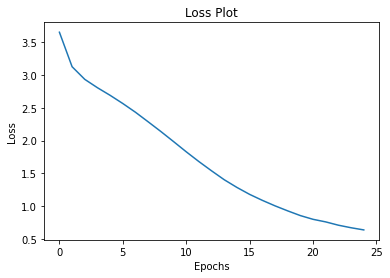

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [30]:
def predict(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(tf.constant(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [31]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: [UNK] Бул мен даракка [UNK]


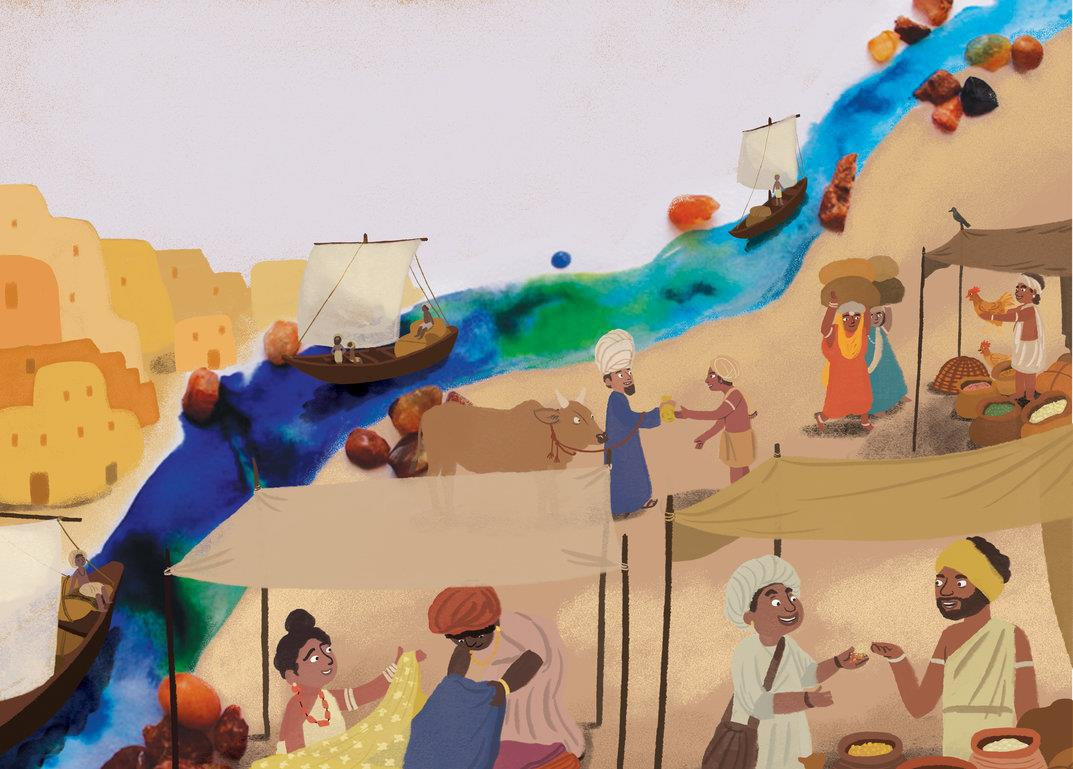

In [32]:
# Predict a caption for a random test image
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
result, attention_plot = predict(image)
predicted_caption = ' '.join(result).replace(' <end>', '')
print('Prediction Caption:', predicted_caption)

# Display image
from IPython.display import Image as im
im(filename=image) 

#

# Generating Output File with Prediction

## My Code for Prediction

### Test Data preparation

In [37]:
import pandas as pd
from datasets import Dataset, DatasetDict
# from google.colab import drive
# drive.mount('/content/gdrive')

op_lang = 'kir' # for Kyrgyz
# op_lang = 'hau' # for Hausa
# op_lang = 'tha' # for Thai

# Importing Testing Dataset from Google Drive and preparing for processing
# mytest_path = 'gdrive/My Drive/Developer/Datasets/purdue_image_captioning/test.csv'
# mytest_df = pd.read_csv(mytest_path)
mytest_df = pd.read_csv('test.csv')
mytest_df['Id'] = mytest_df.Id.str.split(pat='_', expand=True)[0]

testlang_df = mytest_df[mytest_df['ISO639-3'] == op_lang].reset_index(drop= True)
testlang_df = testlang_df.rename( columns={'Id' : 'image_id','ImageURL' : 'image_url'})

# Converting DataFrame to DatasetDict
testdf = Dataset.from_pandas(testlang_df)
df = DatasetDict()
df['test'] = testdf

In [41]:
USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (255, 255, 255))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 12

In [59]:
# Forming Final Output Dataframe
op_df = testlang_df[['image_id']]
op_df = op_df.rename(columns={'image_id':'Id'})

# Getting the image path out of image urls
df = df.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

# Function to map image_id and generate Image Caption
def generate_caption(image_id):
  image = df['test'][df['test']['image_id']== image_id]['image_path']
  result, attention_plot = predict(image)
  caption = ' '.join(result).replace(' <end>', '')
  return caption

# Generate caption column
op_df['Predicted'] = op_df['Id'].apply(generate_caption)

# Function to cleanup Unknown words
def clear_strng(caption):
    caption = caption.replace('[UNK]','').replace(' +','')
    return caption

op_df['Predicted'] = op_df.Predicted.apply(clear_strng)

# Generate Output File to Google Drive location
# op_df.to_csv('gdrive/My Drive/Developer/Datasets/purdue_image_captioning/Kir_Predicted.csv')

op_file = 'Kir_Predicted_captions.csv'
# op_file = 'Hau_Predicted_captions.csv'
# op_file = 'Tha_Predicted_captions.csv'

op_df.to_csv(op_file)

  0%|          | 0/1 [00:00<?, ?ba/s]